# Лабораторная №1
## 0) Описание задачи
### Датасет: TMDB 5000 Movie Dataset
https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv . Ранее это был датасет IMDB, но после полученных от них страйков (авторские права), Kaggle взяли данные с другого сайта, удалив часть колонок и добавив новые.

Данные: описания около 4800 фильмов по таким параметрам, как бюджет, жанры, ключевые слова, язык, название, и т.д. (tmdb_5000_movies.csv); в отдельном файле есть титры для каждого фильма (tmdb_5000_credits.csv)

Эта задача по идее - задача регрессии (по показателю vote_average, который по идее float). Соответственно, датасет сильно разбалансирован (большинство фильмов оценено в районе от 5 до 7). Округлив оценки до целых, мы можем решить эту задачу классификационно (предварительно, классы - от 1 до 10).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from tqdm import tqdm

## 1) Чтение данных

In [2]:
data = pd.read_csv('tmdb_5000_movies.csv', sep=',')
data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Для начала, избавимся от колонки homepage, которую нельзя задействовать as-is (требуется индивидуальный скрапинг сайтов, если как-то хочется использовать их данные, и сейчас это иррационально), от id (в ней отсутствует информация) и от original_language (совпадает со spoken_languages, в которой к тому же больше информации), и от status (100% Released)

In [3]:
data = data.drop(['homepage', 'id', 'original_language', 'status'], axis=1)

Title и Original Title идентичны, но во втором документе (с титрами) встречается под названием Title, так что избавляемся от второго.

In [4]:
data = data.drop('original_title', axis=1)

### JSON

Теперь обратим внимание на json-запакованные данные. Здесь для каждой ячейки может быть несколько значений. Распакуем json-запакованные данные.

In [5]:
import json

In [6]:
genres = []
for a in tqdm(data.genres):
    genres.append(json.loads(a))
g_stat = set([b['name'] for b in sum(genres, [])])
len(g_stat)

100%|██████████████████████████████████| 4803/4803 [00:00<00:00, 106659.12it/s]


20

Категориальные; всего 20 уникальных значений, так что в дальнейшем кодируем в one-hot.

In [7]:
genres = [('|').join([b['name'] for b in g]).replace('Science Fiction', 'SciFi').replace('TV Movie', 'TV') for g in genres]
genres[:4]

['Action|Adventure|Fantasy|SciFi',
 'Adventure|Fantasy|Action',
 'Action|Adventure|Crime',
 'Action|Crime|Drama|Thriller']

Заменим данные распакованными сразу.

In [8]:
data.drop('genres', axis = 1, inplace = True)
data.insert(1, 'genres', genres)

In [9]:
keywords = []
for a in tqdm(data.keywords):
    keywords.append(json.loads(a))
k_stats = set([b['name'] for b in sum(keywords, [])])
len(k_stats)

100%|███████████████████████████████████| 4803/4803 [00:00<00:00, 38704.68it/s]


9813

In [10]:
list(k_stats)[:5]

['flight', 'thesis', 'miner', 'niagara falls', 'femme fatale']

In [11]:
len(set(' '.join(k_stats).split()))

7282

Данные языковые, очень много уникальных значений на всех уровнях, так что, вероятнее всего, будем использовать эмбеддинги.

In [12]:
keywords = [(', ').join([b['name'] for b in k]) for k in keywords]
keywords[:4]

['culture clash, future, space war, space colony, society, space travel, futuristic, romance, space, alien, tribe, alien planet, cgi, marine, soldier, battle, love affair, anti war, power relations, mind and soul, 3d',
 "ocean, drug abuse, exotic island, east india trading company, love of one's life, traitor, shipwreck, strong woman, ship, alliance, calypso, afterlife, fighter, pirate, swashbuckler, aftercreditsstinger",
 'spy, based on novel, secret agent, sequel, mi6, british secret service, united kingdom',
 'dc comics, crime fighter, terrorist, secret identity, burglar, hostage drama, time bomb, gotham city, vigilante, cover-up, superhero, villainess, tragic hero, terrorism, destruction, catwoman, cat burglar, imax, flood, criminal underworld, batman']

In [13]:
data.drop('keywords', axis = 1, inplace = True)
data.insert(2, 'keywords', keywords)

In [14]:
comps = []
for a in tqdm(data.production_companies):
    comps.append(json.loads(a))
co_stats = set([b['name'] for b in sum(comps, [])])
len(co_stats)

100%|██████████████████████████████████| 4803/4803 [00:00<00:00, 102126.88it/s]


5017

In [15]:
len(set(' '.join(co_stats).split()))

5287

То же, что и с keywords

In [16]:
comps = [('|').join([b['name'] for b in c]) for c in comps]

data.drop('production_companies', axis = 1, inplace = True)
data.insert(5, 'production_companies', comps)

In [17]:
json.loads(data.production_countries[101])

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [18]:
states = []
for a in tqdm(data.production_countries):
    states.append(json.loads(a))
states_stats = set([b['iso_3166_1'] for b in sum(states, [])])
len(states_stats)

100%|██████████████████████████████████| 4803/4803 [00:00<00:00, 129719.07it/s]


88

In [19]:
states[:4]

[[{'iso_3166_1': 'US', 'name': 'United States of America'},
  {'iso_3166_1': 'GB', 'name': 'United Kingdom'}],
 [{'iso_3166_1': 'US', 'name': 'United States of America'}],
 [{'iso_3166_1': 'GB', 'name': 'United Kingdom'},
  {'iso_3166_1': 'US', 'name': 'United States of America'}],
 [{'iso_3166_1': 'US', 'name': 'United States of America'}]]

Здесь уникальных значений относительно немного, но one-hot все равно получится разреженный. Есть вариант использовать двоичное кодирование и суммировать получившиеся показатели (поскольку их несколько для каждого фильма), но тогда слишком много групп языков могут совпасть по значениям при сложении. Так, если 1 - RU, 2 - GB, 3 - US, то русско-британский фильм - 0 1 1, как и американский. Более того, многие страны могут встречаться очень редко. Если бы значение на фильм было одно, то это позволило бы серьёзно уменьшить размерность, но здесь мы будем использовать one-hot, с дальнейшим dimensionality reduction.

In [20]:
states = [('|').join([b['iso_3166_1'] for b in s]) for s in states]

data.drop('production_countries', axis = 1, inplace = True)
data.insert(6, 'production_countries', states)

In [21]:
json.loads(data.spoken_languages[101])

[{'iso_639_1': 'de', 'name': 'Deutsch'},
 {'iso_639_1': 'en', 'name': 'English'},
 {'iso_639_1': 'es', 'name': 'Español'},
 {'iso_639_1': 'fr', 'name': 'Français'},
 {'iso_639_1': 'ru', 'name': 'Pусский'}]

In [22]:
langs = []
for a in tqdm(data.spoken_languages):
    langs.append(json.loads(a))
lang_stats = set([b['iso_639_1'] for b in sum(langs, [])])
len(lang_stats)

100%|██████████████████████████████████| 4803/4803 [00:00<00:00, 109076.57it/s]


87

In [23]:
langs[:3]

[[{'iso_639_1': 'en', 'name': 'English'},
  {'iso_639_1': 'es', 'name': 'Español'}],
 [{'iso_639_1': 'en', 'name': 'English'}],
 [{'iso_639_1': 'fr', 'name': 'Français'},
  {'iso_639_1': 'en', 'name': 'English'},
  {'iso_639_1': 'es', 'name': 'Español'},
  {'iso_639_1': 'it', 'name': 'Italiano'},
  {'iso_639_1': 'de', 'name': 'Deutsch'}]]

Ситуация практически идентичная с предыдущим столбцом, но эти два столбца не взаимозаменяемые, потому что в, например, американском фильме могут говорить и на русском, и на испанском, и на китайском. Представляем, однако, так же.

In [24]:
langs = [('|').join([b['iso_639_1'] for b in l]) for l in langs]

data.drop('spoken_languages', axis = 1, inplace = True)
data.insert(10, 'spoken_languages', langs)

In [25]:
data.head()

,budget,genres,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,237000000,Action|Adventure|Fantasy|SciFi,"culture clash, future, space war, space colony...","In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners|Twentieth Century Fox ...,US|GB,2009-12-10,2787965087,162.0,en|es,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,Adventure|Fantasy|Action,"ocean, drug abuse, exotic island, east india t...","Captain Barbossa, long believed to be dead, ha...",139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,US,2007-05-19,961000000,169.0,en,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,Action|Adventure|Crime,"spy, based on novel, secret agent, sequel, mi6...",A cryptic message from Bond’s past sends him o...,107.376788,Columbia Pictures|Danjaq|B24,GB|US,2015-10-26,880674609,148.0,fr|en|es|it|de,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,Action|Crime|Drama|Thriller,"dc comics, crime fighter, terrorist, secret id...",Following the death of District Attorney Harve...,112.312950,Legendary Pictures|Warner Bros.|DC Entertainme...,US,2012-07-16,1084939099,165.0,en,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,Action|Adventure|SciFi,"based on novel, mars, medallion, space travel,...","John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,US,2012-03-07,284139100,132.0,en,"Lost in our world, found in another.",John Carter,6.1,2124


Теперь, когда мы в каком-то виде распаковали JSON-значения, можно визуализировать.

## 2) Визуализация данных

In [26]:
print(data.shape)
print(data.columns)

(4803, 15)
Index(['budget', 'genres', 'keywords', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'tagline', 'title',
       'vote_average', 'vote_count'],
      dtype='object')


In [27]:
data.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


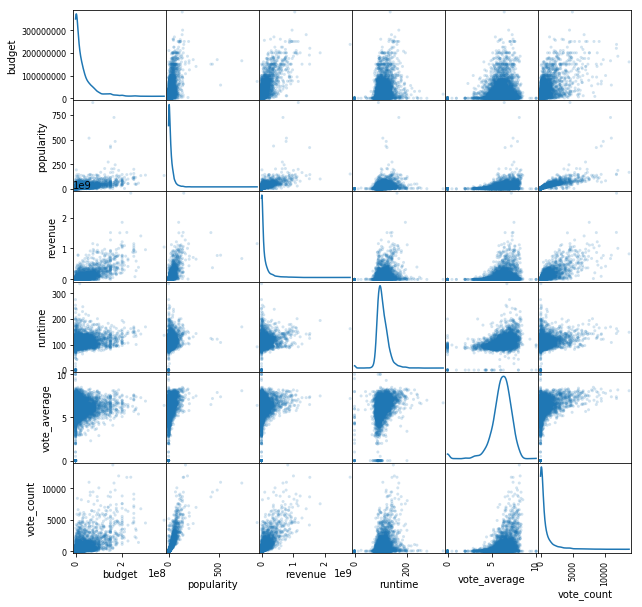

In [28]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = 0.2, figsize = (10, 10), diagonal='kde')
pass

In [29]:
data.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.505414,0.730823,0.269851,0.093146,0.593180
popularity,0.505414,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,0.778130,0.781487,0.271944,0.312997,1.000000


Как мы видим, vote_average не слишком коррелирует с этими показателями. Можно предположить, что оно больше зависит от оставшихся за пределами этого анализа категориальных / текстовых данных. С другой стороны, можно увидеть, что довольно высока корреляция между популярностью фильма, его сборами и тем, сколько за него проголосовало человек. Также заметна связь между бюджетом фильма и его сборами. Имеет смысл избавиться от нескольких высоко коррелирующих показателей, поскольку у них очень похожие тренды.

 Так, можно предположить, что более популярный фильм собирает больше денег, и revenue важнее бюджета, и популярность фильма важнее числа голосов. Так что оставляем popularity и revenue (плюс, из этих четырёх, корреляция между этой парой минимальна).

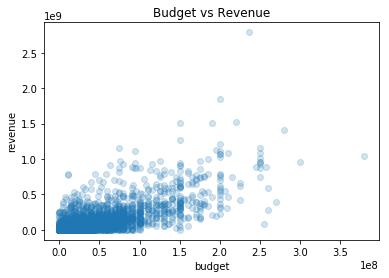

In [30]:
plt.plot(data['budget'], data['revenue'], 'o', alpha = 0.2)
plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('Budget vs Revenue')
pass

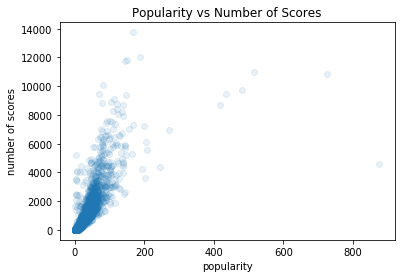

In [31]:
plt.plot(data['popularity'], data['vote_count'], 'o', alpha = 0.1)
plt.xlabel('popularity')
plt.ylabel('number of scores')
plt.title('Popularity vs Number of Scores')
pass

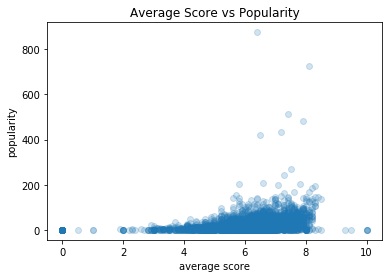

In [32]:
plt.plot(data['vote_average'], data['popularity'], 'o', alpha = 0.2)
plt.xlabel('average score')
plt.ylabel('popularity')
plt.title('Average Score vs Popularity')
pass

Избавляемся от колонок, которые решили исключить.

In [33]:
data = data.drop(['budget', 'vote_count'], axis = 1)
data.head()

,genres,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average
0,Action|Adventure|Fantasy|SciFi,"culture clash, future, space war, space colony...","In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners|Twentieth Century Fox ...,US|GB,2009-12-10,2787965087,162.0,en|es,Enter the World of Pandora.,Avatar,7.2
1,Adventure|Fantasy|Action,"ocean, drug abuse, exotic island, east india t...","Captain Barbossa, long believed to be dead, ha...",139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,US,2007-05-19,961000000,169.0,en,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9
2,Action|Adventure|Crime,"spy, based on novel, secret agent, sequel, mi6...",A cryptic message from Bond’s past sends him o...,107.376788,Columbia Pictures|Danjaq|B24,GB|US,2015-10-26,880674609,148.0,fr|en|es|it|de,A Plan No One Escapes,Spectre,6.3
3,Action|Crime|Drama|Thriller,"dc comics, crime fighter, terrorist, secret id...",Following the death of District Attorney Harve...,112.312950,Legendary Pictures|Warner Bros.|DC Entertainme...,US,2012-07-16,1084939099,165.0,en,The Legend Ends,The Dark Knight Rises,7.6
4,Action|Adventure|SciFi,"based on novel, mars, medallion, space travel,...","John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,US,2012-03-07,284139100,132.0,en,"Lost in our world, found in another.",John Carter,6.1


In [34]:
data.corr()

,popularity,revenue,runtime,vote_average
popularity,1.000000,0.644724,0.225502,0.273952
revenue,0.644724,1.000000,0.251093,0.197150
runtime,0.225502,0.251093,1.000000,0.375046
vote_average,0.273952,0.197150,0.375046,1.000000


## 3) Обработка пропущенных значений

In [35]:
data.isna().sum()

genres                    0
keywords                  0
overview                  3
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
spoken_languages          0
tagline                 844
title                     0
vote_average              0
dtype: int64

Tagline и overview - текстовые данные, так что можно заполнять пустой строкой.

In [36]:
tagline = data['tagline'].fillna('')
data.drop('tagline', axis = 1, inplace = True)
data.insert(11, 'tagline', tagline)
overview = data['overview'].fillna('')
data.drop('overview', axis = 1, inplace = True)
data.insert(3, 'overview', overview)

Runtime - длина фильма, можно спокойно заполнять average.

In [37]:
runtime = data['runtime'].fillna(data['runtime'].median(axis = 0))
data.drop('runtime', axis = 1, inplace = True)
data.insert(9, 'runtime', runtime)

Дата пропущена всего в одной строке, можно спокойно эту строку отбросить.

In [38]:
data = data.dropna()

In [39]:
data.isna().sum()

genres                  0
keywords                0
popularity              0
overview                0
production_companies    0
production_countries    0
release_date            0
revenue                 0
spoken_languages        0
runtime                 0
title                   0
tagline                 0
vote_average            0
dtype: int64

Прежде, чем переходить к категориальным признакам, могли бы преобразовать release date в unix-timestamp'ы (так можно будет использовать эти данные напрямую), но некоторые раньше unix-timestamp, так что возьмём разницу с самым ранним фильмом (1888 г., но мы укажем 1887).

In [59]:
import time
import datetime

t = datetime.datetime.strptime('1887-01-01', "%Y-%m-%d")

stamps = [(t-datetime.datetime.strptime(str(a), "%Y-%m-%d")).total_seconds() for a in data['release_date']]
data.drop('release_date', axis = 1, inplace = True)
data.insert(7, 'release_date', stamps)

In [60]:
data.head()

,genres,keywords,popularity,overview,production_companies,production_countries,revenue,release_date,spoken_languages,runtime,title,tagline,vote_average
0,Action|Adventure|Fantasy|SciFi,"culture clash, future, space war, space colony...",150.437577,"In the 22nd century, a paraplegic Marine is di...",Ingenious Film Partners|Twentieth Century Fox ...,US|GB,2787965087,-3.879619e+09,en|es,162.0,Avatar,Enter the World of Pandora.,7.2
1,Adventure|Fantasy|Action,"ocean, drug abuse, exotic island, east india t...",139.082615,"Captain Barbossa, long believed to be dead, ha...",Walt Disney Pictures|Jerry Bruckheimer Films|S...,US,961000000,-3.798749e+09,en,169.0,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",6.9
2,Action|Adventure|Crime,"spy, based on novel, secret agent, sequel, mi6...",107.376788,A cryptic message from Bond’s past sends him o...,Columbia Pictures|Danjaq|B24,GB|US,880674609,-4.065034e+09,fr|en|es|it|de,148.0,Spectre,A Plan No One Escapes,6.3
3,Action|Crime|Drama|Thriller,"dc comics, crime fighter, terrorist, secret id...",112.312950,Following the death of District Attorney Harve...,Legendary Pictures|Warner Bros.|DC Entertainme...,US,1084939099,-3.961613e+09,en,165.0,The Dark Knight Rises,The Legend Ends,7.6
4,Action|Adventure|SciFi,"based on novel, mars, medallion, space travel,...",43.926995,"John Carter is a war-weary, former military ca...",Walt Disney Pictures,US,284139100,-3.950294e+09,en,132.0,John Carter,"Lost in our world, found in another.",6.1


## 4) Обработка категориальных признаков

Прежде всего, приведём колонку vote_average к нужному виду (округление, категориальное значение, поскольку это метка класса)

In [61]:
data['vote_average'] = data['vote_average'].apply(lambda x: str(int(round(x, 0))))

In [62]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['genres', 'keywords', 'overview', 'production_companies', 'production_countries', 'spoken_languages', 'title', 'tagline', 'vote_average']
['popularity', 'revenue', 'release_date', 'runtime']


In [63]:
data.describe(include = [object])

,genres,keywords,overview,production_companies,production_countries,spoken_languages,title,tagline,vote_average
count,4802,4802,4802,4802,4802,4802,4802,4802,4802
unique,1175,4222,4800,3697,469,544,4799,3945,11
top,Drama,,,,US,en,Batman,,6
freq,370,411,3,350,2977,3171,2,843,2073


Genres, так как там всего 20 ключевых слов, эффективнее всего закодировать в one-hot

In [64]:
cleaned_gen = data.genres.str.split('|', expand=True).stack()
cleaned_gen

0     0         Action
      1      Adventure
      2        Fantasy
      3          SciFi
1     0      Adventure
              ...     
4800  1          Drama
      2        Romance
      3             TV
4801  0               
4802  0    Documentary
Length: 12187, dtype: object

In [65]:
genres = pd.get_dummies(cleaned_gen, prefix='g').groupby(level = 0).sum().drop('g_', axis=1)
genres.head()

,g_Action,g_Adventure,g_Animation,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,g_Foreign,g_History,g_Horror,g_Music,g_Mystery,g_Romance,g_SciFi,g_TV,g_Thriller,g_War,g_Western
0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [66]:
cleaned_co = data.production_countries.str.split('|', expand=True).stack()
cleaned_co

0     0    US
      1    GB
1     0    US
2     0    GB
      1    US
           ..
4799  0      
4800  0    US
4801  0    US
      1    CN
4802  0    US
Length: 6609, dtype: object

In [67]:
states = pd.get_dummies(cleaned_co, prefix='c').groupby(level = 0).sum().drop('c_', axis=1)
states.head()

,c_AE,c_AF,c_AO,c_AR,c_AT,c_AU,c_AW,c_BA,c_BE,c_BG,...,c_SG,c_SI,c_SK,c_TH,c_TN,c_TR,c_TW,c_UA,c_US,c_ZA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [68]:
cleaned_lan = data.spoken_languages.str.split('|', expand=True).stack()
cleaned_lan

0     0    en
      1    es
1     0    en
2     0    fr
      1    en
           ..
4798  0    es
4799  0      
4800  0    en
4801  0    en
4802  0    en
Length: 7022, dtype: object

In [69]:
langs = pd.get_dummies(cleaned_lan, prefix='l').groupby(level = 0).sum().drop('l_', axis=1)
langs.head()

,l_af,l_am,l_ar,l_bg,l_bm,l_bn,l_bo,l_br,l_bs,l_ca,...,l_tr,l_uk,l_ur,l_vi,l_wo,l_xh,l_xx,l_yi,l_zh,l_zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Остаются Keywords, Overview, Production_Companies, Tagline и Title.

In [70]:
data[['keywords', 'overview', 'production_companies', 'tagline', 'title']].head()

,keywords,overview,production_companies,tagline,title
0,"culture clash, future, space war, space colony...","In the 22nd century, a paraplegic Marine is di...",Ingenious Film Partners|Twentieth Century Fox ...,Enter the World of Pandora.,Avatar
1,"ocean, drug abuse, exotic island, east india t...","Captain Barbossa, long believed to be dead, ha...",Walt Disney Pictures|Jerry Bruckheimer Films|S...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End
2,"spy, based on novel, secret agent, sequel, mi6...",A cryptic message from Bond’s past sends him o...,Columbia Pictures|Danjaq|B24,A Plan No One Escapes,Spectre
3,"dc comics, crime fighter, terrorist, secret id...",Following the death of District Attorney Harve...,Legendary Pictures|Warner Bros.|DC Entertainme...,The Legend Ends,The Dark Knight Rises
4,"based on novel, mars, medallion, space travel,...","John Carter is a war-weary, former military ca...",Walt Disney Pictures,"Lost in our world, found in another.",John Carter


Keywords, Overview, Tagline и Title все являются текстовыми характеристиками непосредственно фильма, их можно объединить в один текст и репрезентировать вместе (используя, например, предобученную на Wiki GLoVE модель). С другой стороны, production_companies надо представлять отдельно. Для этого попробуем найти в интернете текст про film production companies, соскрапим его и обучим отдельную модель самостоятельно. Этот шаг, чтобы не перегружать главный jupyter файл, я произвёл в отдельном файле 'Production Embeddings.ipynb'

Итак, мы обучили модель размерностью 50 и сохранили её в папке models (а заодно скачали модели glove с http://nlp.stanford.edu/data/glove.6B.zip, и будем использовать их для представления текстовой информации про сам фильм).

Сначала займёмся Production companies.

In [71]:
prod_comps = [a.lower().replace('|', ' ') for a in data['production_companies']]

In [72]:
prod_comps[:4]

['ingenious film partners twentieth century fox film corporation dune entertainment lightstorm entertainment',
 'walt disney pictures jerry bruckheimer films second mate productions',
 'columbia pictures danjaq b24',
 'legendary pictures warner bros. dc entertainment syncopy']

In [73]:
from gensim.models import doc2vec, KeyedVectors
from nltk.tokenize import word_tokenize

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [75]:
prod_model = doc2vec.Doc2Vec.load('models/prod_companies.d2v')

In [76]:
prod_vectors = [prod_model.infer_vector(word_tokenize(p)) for p in tqdm(prod_comps)]

100%|█████████████████████████████████████| 4802/4802 [00:06<00:00, 716.21it/s]


In [77]:
prod_vectors = pd.DataFrame(np.array(prod_vectors)).add_prefix('pv_')
prod_vectors.head()

,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,pv_6,pv_7,pv_8,pv_9,...,pv_40,pv_41,pv_42,pv_43,pv_44,pv_45,pv_46,pv_47,pv_48,pv_49
0,0.033497,0.024114,-0.001031,0.019850,-0.008635,0.000235,0.006738,-0.005843,-0.017331,0.001897,...,-0.003813,0.000201,-0.019260,0.002616,0.023257,-0.017422,-0.015532,0.031879,-0.006245,0.010281
1,-0.005825,-0.015750,0.003953,-0.004376,0.004621,0.006462,0.014043,-0.019922,0.007507,0.003603,...,0.003712,-0.002921,-0.044665,-0.011523,0.026668,-0.027497,-0.013845,0.059076,0.004366,-0.001917
2,-0.000768,-0.014211,-0.007009,0.004806,0.015154,0.008637,0.001154,-0.022561,0.002541,-0.002475,...,0.001382,0.005503,-0.044696,0.006155,0.022961,-0.009619,0.004733,0.032264,-0.012244,-0.009321
3,0.010446,-0.006759,-0.011227,0.012027,0.012999,0.000929,-0.000402,-0.005791,-0.000487,0.015031,...,0.011394,-0.014813,-0.048943,-0.006272,0.026997,-0.014084,-0.015305,0.061184,0.003492,-0.003530
4,0.003469,0.001171,0.012162,0.006199,0.014189,0.017773,0.002513,-0.008675,0.007788,0.003385,...,0.014817,-0.010193,-0.017973,-0.005050,0.007379,-0.016792,-0.007187,0.019412,-0.003135,0.000981


Теперь Texts. Сначала преобразуем glove-txt формат в читаемый gensim'ом, затем загрузим. (используем 50d модель)

In [79]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'models/glove.6B.50d.txt'
word2vec_output_file = 'models/glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 50)

In [80]:
text_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

Объединим тексты и подвергнем базовой предобработке.

In [81]:
film_desc = data['title'] + ' ' + data ['tagline'] + ' ' + data['overview'] + ' ' + data['keywords']

In [82]:
data.insert(0, 'film_desc', film_desc)

In [83]:
data = data.drop(['title', 'tagline', 'overview', 'keywords'], axis=1)

In [84]:
data['film_desc'].head()

0    Avatar Enter the World of Pandora. In the 22nd...
1    Pirates of the Caribbean: At World's End At th...
2    Spectre A Plan No One Escapes A cryptic messag...
3    The Dark Knight Rises The Legend Ends Followin...
4    John Carter Lost in our world, found in anothe...
Name: film_desc, dtype: object

Нижний регистр:

In [85]:
data['film_desc'] = data['film_desc'].apply(lambda x: " ".join(x.lower() for x in x.split()))

Пунктуация:

In [86]:
data['film_desc'] = data['film_desc'].str.replace('[^\w\s]','')

Стоп-слова:

In [87]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [88]:
data['film_desc'] = data['film_desc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [89]:
data['film_desc'].head()

0    avatar enter world pandora 22nd century parapl...
1    pirates caribbean worlds end end world adventu...
2    spectre plan one escapes cryptic message bonds...
3    dark knight rises legend ends following death ...
4    john carter lost world found another john cart...
Name: film_desc, dtype: object

In [90]:
film_desc = data['film_desc']

Получим векторы описаний как среднее из векторов их слов.

In [91]:
film_vecs = []
for d in tqdm(film_desc):
    words = word_tokenize(d)
    sen_vec = []
    
    for w in words:
        try:
            sen_vec.append(text_model[w])
        except KeyError:
            sen_vec.append(np.zeros((50,))) # Незнакомые слова заменяем нулевым вектором размерностью 50.
            
    film_vecs.append((sum(sen_vec)/len(sen_vec)))

100%|█████████████████████████████████████| 4802/4802 [00:04<00:00, 927.62it/s]


In [92]:
film_vecs = pd.DataFrame(np.array(film_vecs)).add_prefix('fv_')
film_vecs.head()

,fv_0,fv_1,fv_2,fv_3,fv_4,fv_5,fv_6,fv_7,fv_8,fv_9,...,fv_40,fv_41,fv_42,fv_43,fv_44,fv_45,fv_46,fv_47,fv_48,fv_49
0,0.531405,0.179213,-0.155967,0.113932,0.419502,-0.060702,-0.197788,-0.202166,0.154574,-0.152241,...,-0.124251,-0.164119,0.182848,-0.001532,-0.019719,0.195204,0.095673,-0.368016,-0.221205,-0.181242
1,0.361225,0.106471,-0.237256,0.033109,0.270578,0.065713,-0.431070,0.003698,0.109686,0.049607,...,-0.215962,0.096166,0.250031,-0.032547,-0.024640,0.178960,-0.093781,-0.415753,-0.109149,-0.152448
2,0.498656,0.126325,0.071108,-0.105813,0.304617,0.137019,-0.188828,0.019941,0.027703,-0.116722,...,0.103751,-0.038581,0.142066,0.031060,0.073086,-0.106637,0.082048,0.096360,-0.022317,-0.194130
3,0.253731,-0.125228,-0.047040,-0.035165,0.277459,0.196237,-0.092441,-0.016844,-0.026922,-0.096220,...,-0.240868,0.219853,-0.000032,-0.155341,0.015613,0.005096,-0.111313,-0.267023,0.154081,-0.089913
4,0.399089,0.213234,-0.038033,0.030219,0.363641,0.162319,-0.329201,-0.093223,0.136812,0.018301,...,-0.160034,0.011944,0.112740,-0.051141,-0.115590,0.214860,0.096970,-0.366724,-0.193291,-0.322370


## 5) Нормализация

Нормализуем количественные признаки (репрезентированные категориальные уже бинарны / находятся на интервале (-1, 1))

In [93]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,popularity,revenue,release_date,runtime
count,4802.000000,4.802000e+03,4.802000e+03,4802.000000
mean,21.496776,8.227777e+07,-3.660249e+09,106.896501
std,31.818451,1.628697e+08,3.913129e+08,22.557033
min,0.000372,0.000000e+00,-4.105296e+09,0.000000
25%,4.671734,0.000000e+00,-3.917030e+09,94.000000
50%,12.924931,1.917498e+07,-3.747514e+09,103.000000
75%,28.332017,9.291920e+07,-3.551126e+09,117.750000
max,875.581305,2.787965e+09,-9.364032e+08,338.000000


In [94]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [95]:
data_numerical.describe()

,popularity,revenue,release_date,runtime
count,4.802000e+03,4.802000e+03,4.802000e+03,4.802000e+03
mean,-1.018020e-15,7.102468e-17,-2.367489e-16,4.734979e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.755956e-01,-5.051753e-01,-1.137318e+00,-4.738943e+00
25%,-5.287826e-01,-5.051753e-01,-6.562055e-01,-5.717286e-01
50%,-2.693986e-01,-3.874433e-01,-2.230053e-01,-1.727400e-01
75%,2.148200e-01,6.533704e-02,2.788622e-01,4.811581e-01
max,2.684243e+01,1.661259e+01,6.960787e+00,1.024530e+01


### Соединим данные в одну таблицу.

In [96]:
data = pd.concat((data_numerical, prod_vectors, film_vecs, genres, states, langs, data.vote_average), axis=1)

In [97]:
data.shape

(4803, 300)

In [98]:
data.isna().sum()

popularity      1
revenue         1
release_date    1
runtime         1
pv_0            1
               ..
l_xx            1
l_yi            1
l_zh            1
l_zu            1
vote_average    1
Length: 300, dtype: int64

In [99]:
data.dropna().shape

(4801, 300)

Потери небольшие, так и оставим.

In [100]:
data = data.dropna()
data.head()

,popularity,revenue,release_date,runtime,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,...,l_uk,l_ur,l_vi,l_wo,l_xh,l_xx,l_yi,l_zh,l_zu,vote_average
0,4.052391,16.612585,-0.560601,2.442852,0.033497,0.024114,-0.001031,0.019850,-0.008635,0.000235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,3.695524,5.395246,-0.353937,2.753177,-0.005825,-0.015750,0.003953,-0.004376,0.004621,0.006462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2.699063,4.902058,-1.034428,1.822203,-0.000768,-0.014211,-0.007009,0.004806,0.015154,0.008637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,2.854198,6.156216,-0.770136,2.575848,0.010446,-0.006759,-0.011227,0.012027,0.012999,0.000929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,0.704944,1.239404,-0.741212,1.112890,0.003469,0.001171,0.012162,0.006199,0.014189,0.017773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [101]:
data.describe()

,popularity,revenue,release_date,runtime,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,...,l_tr,l_uk,l_ur,l_vi,l_wo,l_xh,l_xx,l_yi,l_zh,l_zu
count,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,...,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,0.000128,0.000105,0.000044,0.000156,0.007898,-0.006469,-0.001386,-0.002513,0.003633,0.004874,...,0.003749,0.001875,0.003124,0.003541,0.000208,0.000833,0.000417,0.001666,0.022287,0.000833
std,1.000065,1.000078,1.000100,1.000046,0.016491,0.016941,0.010322,0.011481,0.013194,0.013912,...,0.061122,0.043261,0.055814,0.059406,0.014432,0.028855,0.020408,0.040791,0.147631,0.028855
min,-0.675596,-0.505175,-1.137318,-4.738943,-0.142626,-0.091752,-0.045046,-0.063411,-0.062072,-0.086193,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.528516,-0.505175,-0.656205,-0.571729,0.000798,-0.016430,-0.007732,-0.009273,-0.003361,-0.002731,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.269294,-0.387413,-0.223447,-0.172740,0.007593,-0.006427,-0.000527,-0.001861,0.002725,0.003886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.215402,0.065349,0.278862,0.492241,0.016695,0.003817,0.004847,0.003859,0.011293,0.012811,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.842430,16.612585,6.960787,10.245297,0.101542,0.127367,0.049643,0.080949,0.084943,0.068643,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Сохраним данные, чтобы заново потом ничего не представлять.

In [102]:
data.to_csv('tmdb_prepped.csv', index=False)

## 6) X и y

In [111]:
data = pd.read_csv('tmdb_prepped.csv').astype({'vote_average': 'str'})
data.head()

,popularity,revenue,release_date,runtime,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,...,l_uk,l_ur,l_vi,l_wo,l_xh,l_xx,l_yi,l_zh,l_zu,vote_average
0,4.052391,16.612585,-0.560601,2.442852,0.033497,0.024114,-0.001031,0.019850,-0.008635,0.000235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,3.695524,5.395246,-0.353937,2.753177,-0.005825,-0.015750,0.003953,-0.004376,0.004621,0.006462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2.699063,4.902058,-1.034428,1.822203,-0.000768,-0.014211,-0.007009,0.004806,0.015154,0.008637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,2.854198,6.156216,-0.770136,2.575848,0.010446,-0.006759,-0.011227,0.012027,0.012999,0.000929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,0.704944,1.239404,-0.741212,1.112890,0.003469,0.001171,0.012162,0.006199,0.014189,0.017773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


Посмотрим на баланс классов.

In [112]:
data['vote_average'].value_counts()

6     2072
7     1394
5      679
8      331
4      195
0       63
3       48
2       11
10       5
1        2
9        1
Name: vote_average, dtype: int64

Как мы видим, датасет КРАЙНЕ несбалансирован (в одном классе всего одно значение), и было бы разумнее рассматривать задачу с позиции регрессии; но мы работаем с классификацией.

В реальных условиях рассмотрения фильма среднестатистическим пользователем, любая оценка от "4" воспринимается им как очень плохой фильм (который однозначно не стоит смотреть), а любая оценка от "8" как очень хороший фильм (который стоит посмотреть); плюс "extremes" на таких сайтах довольно редки. В условиях ограниченности данных, вероятнее всего (если всё же рассматривать эту задачу как классификационную, а не регрессионную), стоит объединить extremes в соответствующие группы (as-is это скорее выбросы).

In [113]:
repl_d = {'10': '>=8', '9': '>=8', '8': '>=8', '4': '<=4', '3': '<=4', '2': '<=4', '1': '<=4', '0': '<=4'}

data = data.replace({'vote_average': repl_d})

In [114]:
data['vote_average']

0         7
1         7
2         6
3       >=8
4         6
       ... 
4796    >=8
4797      7
4798      6
4799      7
4800      6
Name: vote_average, Length: 4801, dtype: object

In [115]:
data['vote_average'].value_counts()

6      2072
7      1394
5       679
>=8     337
<=4     319
Name: vote_average, dtype: int64

Теперь условия гораздо лучше!

In [116]:
X = data.drop('vote_average', axis = 1) # выбрасываем столбец 'class'
y = data['vote_average']
feature_names = X.columns

In [117]:
type(feature_names)

pandas.core.indexes.base.Index

In [118]:
X = X.to_numpy()

One-hot'нем метки.

In [119]:
from sklearn.preprocessing import LabelBinarizer

In [120]:
lb = LabelBinarizer()

In [214]:
y = lb.fit_transform(y)
y

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]], dtype=int32)

In [122]:
lb.inverse_transform(y)

array(['7', '7', '6', ..., '6', '7', '6'], dtype='<U3')

In [123]:
lb.classes_

array(['5', '6', '7', '<=4', '>=8'], dtype='<U3')

In [124]:
print(X.shape)
print(y.shape)
N, d = X.shape

(4801, 299)
(4801, 5)


In [125]:
type(X)

numpy.ndarray

In [126]:
type(y)

numpy.ndarray

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 666)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

4320 481


## 7) Модели
### K-NN:

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [129]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test != y_test_predict)

In [130]:
err_test

0.18544698544698546

Подберём оптимальные значения соседей:

In [131]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10, verbose = 0)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.5618055555555556 1


In [132]:
knn = KNeighborsClassifier(n_neighbors = 1)

knn.fit(X_train, y_train)

y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test != y_test_predict)

err_test

0.23035343035343037

In [133]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.26      0.35      0.30        63
           1       0.50      0.52      0.51       207
           2       0.40      0.42      0.41       125
           3       0.52      0.23      0.32        47
           4       0.39      0.31      0.34        39

   micro avg       0.42      0.42      0.42       481
   macro avg       0.41      0.36      0.38       481
weighted avg       0.44      0.42      0.42       481
 samples avg       0.42      0.42      0.42       481



## K-nearest, как правило, не слишком эффективен для задач с данными высокой размерности, а для NLP зачастую лучше работает Naive Bayes. Попробуем другие методы

### SVC:

In [134]:
y_train_full = lb.inverse_transform(y_train)
y_test_full = lb.inverse_transform(y_test)

In [135]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != svc.predict(X_train))
err_test  = np.mean(y_test_full  != svc.predict(X_test))

print(err_train, err_test)

0.5053240740740741 0.5301455301455301


In [136]:
print(classification_report(y_test_full, svc.predict(X_test)))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           5       0.00      0.00      0.00        63
           6       0.48      0.86      0.61       207
           7       0.45      0.38      0.41       125
         <=4       0.00      0.00      0.00        47
         >=8       0.00      0.00      0.00        39

    accuracy                           0.47       481
   macro avg       0.18      0.25      0.20       481
weighted avg       0.32      0.47      0.37       481



### Bayes:

In [137]:
from sklearn.naive_bayes import BernoulliNB

In [138]:
clf = BernoulliNB()
clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test  = np.mean(y_test_full  != clf.predict(X_test))

print(err_train, err_test)

0.5231481481481481 0.5384615384615384


In [139]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.36      0.21      0.26        63
           6       0.51      0.67      0.58       207
           7       0.44      0.42      0.43       125
         <=4       0.29      0.26      0.27        47
         >=8       0.47      0.18      0.26        39

    accuracy                           0.46       481
   macro avg       0.41      0.34      0.36       481
weighted avg       0.45      0.46      0.44       481



Пока наилучшие результаты у наивного байесовского классификатора (что коррелирует с тем, что NB - одна из лучших моделей для NLP-задач. Тем не менее, результаты все равно очень низкие.

###  Extremely Randomized Trees + наиболее информативные фичи:

In [140]:
from sklearn import ensemble

In [141]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print(err_train, err_test)

0.0 0.18711018711018712


In [142]:
print(classification_report(y_test, ert.predict(X_test)))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.59      0.30      0.40       207
           2       0.81      0.10      0.18       125
           3       1.00      0.02      0.04        47
           4       0.00      0.00      0.00        39

   micro avg       0.63      0.16      0.25       481
   macro avg       0.48      0.09      0.13       481
weighted avg       0.56      0.16      0.23       481
 samples avg       0.16      0.16      0.16       481



In [143]:
np.sum(ert.feature_importances_)

1.0000000000000002

In [144]:
importances = ert.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))   

Feature ranking:
 1. feature 'popularity' (0.019220)
 2. feature 'runtime' (0.015058)
 3. feature 'g_Drama' (0.014359)
 4. feature 'release_date' (0.013502)
 5. feature 'revenue' (0.012399)
 6. feature 'g_Comedy' (0.009463)
 7. feature ' fv_2' (0.009116)
 8. feature 'fv_13' (0.009020)
 9. feature 'fv_49' (0.008968)
10. feature 'fv_14' (0.008739)
11. feature 'fv_29' (0.008738)
12. feature 'fv_15' (0.008623)
13. feature 'fv_30' (0.008618)
14. feature ' fv_8' (0.008588)
15. feature 'fv_11' (0.008584)
16. feature 'fv_26' (0.008540)
17. feature 'fv_38' (0.008523)
18. feature ' fv_1' (0.008511)
19. feature 'fv_41' (0.008510)
20. feature 'fv_39' (0.008502)
21. feature ' fv_6' (0.008488)
22. feature 'fv_37' (0.008488)
23. feature 'fv_27' (0.008476)
24. feature 'fv_33' (0.008460)
25. feature 'fv_22' (0.008452)
26. feature 'fv_23' (0.008421)
27. feature 'fv_17' (0.008395)
28. feature 'fv_35' (0.008382)
29. feature ' fv_3' (0.008379)
30. feature 'fv_12' (0.008372)
31. feature 'fv_24' (0.008365)
3

256. feature ' c_SG' (0.000020)
257. feature ' c_EC' (0.000018)
258. feature ' l_ca' (0.000017)
259. feature ' l_mn' (0.000017)
260. feature ' l_iu' (0.000014)
261. feature ' c_GR' (0.000014)
262. feature ' c_RS' (0.000013)
263. feature ' l_sl' (0.000012)
264. feature ' c_FI' (0.000012)
265. feature ' c_LY' (0.000012)
266. feature ' l_to' (0.000012)
267. feature ' c_MY' (0.000011)
268. feature ' c_AF' (0.000011)
269. feature ' c_DM' (0.000010)
270. feature ' l_ps' (0.000010)
271. feature ' l_nv' (0.000009)
272. feature ' l_et' (0.000008)
273. feature ' l_kw' (0.000008)
274. feature ' l_ce' (0.000008)
275. feature ' c_CM' (0.000008)
276. feature ' l_ny' (0.000007)
277. feature ' c_BT' (0.000007)
278. feature ' l_co' (0.000007)
279. feature ' l_tl' (0.000006)
280. feature ' c_NG' (0.000005)
281. feature ' l_am' (0.000004)
282. feature ' l_bs' (0.000004)
283. feature ' c_PA' (0.000004)
284. feature ' c_PH' (0.000004)
285. feature ' c_PT' (0.000003)
286. feature ' l_dz' (0.000003)
287. fea

Как мы видим, все векторные (pv, fv) и изначально численные признаки обладают высокой важностью относительно остальных. Этим же отличается и большая часть "жанровых" признаков (кроме Foreign).

В то же время, можно заметить, что страна производства и языки фильма на рейтинг почти не влияют (за исключением некоторых крупных стран, вроде США, Британии и т.д., и языков, вроде японского, португальского, и китайского.

Исключим все признаки с важностью меньше 0.001: это и уберёт малозначительные фичи, и более, чем в два раза, уменьшит размерность.

In [145]:
toremove = [feature_names[indices[f]] for f in range(d) if importances[indices[f]] < 0.001]

In [146]:
data = data.drop(toremove, axis = 1)

In [147]:
data.describe()

,popularity,revenue,release_date,runtime,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,...,c_US,l_de,l_en,l_es,l_fr,l_it,l_ja,l_pt,l_ru,l_zh
count,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,...,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,0.000128,0.000105,0.000044,0.000156,0.007898,-0.006469,-0.001386,-0.002513,0.003633,0.004874,...,0.823787,0.054572,0.933972,0.073110,0.091023,0.039159,0.020204,0.014164,0.038534,0.022287
std,1.000065,1.000078,1.000100,1.000046,0.016491,0.016941,0.010322,0.011481,0.013194,0.013912,...,0.381041,0.227166,0.248357,0.260344,0.287671,0.193992,0.140713,0.118178,0.192501,0.147631
min,-0.675596,-0.505175,-1.137318,-4.738943,-0.142626,-0.091752,-0.045046,-0.063411,-0.062072,-0.086193,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.528516,-0.505175,-0.656205,-0.571729,0.000798,-0.016430,-0.007732,-0.009273,-0.003361,-0.002731,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.269294,-0.387413,-0.223447,-0.172740,0.007593,-0.006427,-0.000527,-0.001861,0.002725,0.003886,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.215402,0.065349,0.278862,0.492241,0.016695,0.003817,0.004847,0.003859,0.011293,0.012811,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.842430,16.612585,6.960787,10.245297,0.101542,0.127367,0.049643,0.080949,0.084943,0.068643,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [148]:
data.to_csv('tmdb_prepped.csv', index=False)

## Попробуем с новыми значениями!

In [149]:
data = pd.read_csv('tmdb_prepped.csv').astype({'vote_average': 'str'})
data.head()

,popularity,revenue,release_date,runtime,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,...,l_de,l_en,l_es,l_fr,l_it,l_ja,l_pt,l_ru,l_zh,vote_average
0,4.052391,16.612585,-0.560601,2.442852,0.033497,0.024114,-0.001031,0.019850,-0.008635,0.000235,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,3.695524,5.395246,-0.353937,2.753177,-0.005825,-0.015750,0.003953,-0.004376,0.004621,0.006462,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2.699063,4.902058,-1.034428,1.822203,-0.000768,-0.014211,-0.007009,0.004806,0.015154,0.008637,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6
3,2.854198,6.156216,-0.770136,2.575848,0.010446,-0.006759,-0.011227,0.012027,0.012999,0.000929,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,>=8
4,0.704944,1.239404,-0.741212,1.112890,0.003469,0.001171,0.012162,0.006199,0.014189,0.017773,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [150]:
X = data.drop('vote_average', axis = 1) # выбрасываем столбец 'class'
feature_names = X.columns

In [151]:
X = X.to_numpy()

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 666)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

N, d = X.shape

4320 481


In [153]:
y_train_full = lb.inverse_transform(y_train)
y_test_full = lb.inverse_transform(y_test)

## Bayes

In [154]:
clf = BernoulliNB()
clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test  = np.mean(y_test_full  != clf.predict(X_test))

print(err_train, err_test)

0.5368055555555555 0.5176715176715176


In [155]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.41      0.24      0.30        63
           6       0.53      0.68      0.60       207
           7       0.47      0.45      0.46       125
         <=4       0.23      0.23      0.23        47
         >=8       0.71      0.26      0.38        39

    accuracy                           0.48       481
   macro avg       0.47      0.37      0.39       481
weighted avg       0.48      0.48      0.47       481



## K-NN

In [156]:
knn = KNeighborsClassifier(n_neighbors = 1)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [157]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test != y_test_predict)

err_test

0.22702702702702704

In [158]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.27      0.35      0.30        63
           1       0.51      0.52      0.51       207
           2       0.43      0.46      0.44       125
           3       0.50      0.21      0.30        47
           4       0.34      0.26      0.29        39

   micro avg       0.43      0.43      0.43       481
   macro avg       0.41      0.36      0.37       481
weighted avg       0.44      0.43      0.43       481
 samples avg       0.43      0.43      0.43       481



## Neural Network

In [159]:
from sklearn.neural_network import MLPClassifier

In [160]:
nn = MLPClassifier(max_iter = 1000)

nn.fit(X_train, y_train)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [161]:
err_train = np.mean(y_train != nn.predict(X_train))
err_test  = np.mean(y_test  != nn.predict(X_test))

print(err_train, err_test)

0.0002777777777777778 0.2182952182952183


In [162]:
print(classification_report(y_test, nn.predict(X_test)))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.22      0.16      0.18        63
           1       0.53      0.54      0.54       207
           2       0.43      0.44      0.43       125
           3       0.40      0.26      0.31        47
           4       0.39      0.33      0.36        39

   micro avg       0.45      0.42      0.43       481
   macro avg       0.39      0.35      0.37       481
weighted avg       0.44      0.42      0.43       481
 samples avg       0.38      0.42      0.39       481



## Random Forest Classifier

In [163]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0 0.19334719334719336


In [164]:
print(classification_report(y_test, rf.predict(X_test)))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.57      0.21      0.31       207
           2       0.69      0.07      0.13       125
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        39

   micro avg       0.59      0.11      0.19       481
   macro avg       0.25      0.06      0.09       481
weighted avg       0.43      0.11      0.17       481
 samples avg       0.11      0.11      0.11       481



## ADA

In [165]:
ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
ada.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != ada.predict(X_train))
err_test = np.mean(y_test_full != ada.predict(X_test))

print(err_train, err_test)

0.5407407407407407 0.6195426195426196


In [166]:
print(classification_report(y_test_full, ada.predict(X_test)))

              precision    recall  f1-score   support

           5       0.29      0.32      0.30        63
           6       0.50      0.42      0.45       207
           7       0.29      0.32      0.31       125
         <=4       0.42      0.38      0.40        47
         >=8       0.31      0.49      0.38        39

    accuracy                           0.38       481
   macro avg       0.36      0.38      0.37       481
weighted avg       0.40      0.38      0.38       481



## Logistic Regression

In [167]:
from sklearn.linear_model import LogisticRegression

In [168]:
clf = LogisticRegression(random_state = 0)

# Train model
model = clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4650462962962963 0.49480249480249483


In [169]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.30      0.05      0.08        63
           6       0.53      0.80      0.64       207
           7       0.45      0.50      0.48       125
         <=4       0.60      0.13      0.21        47
         >=8       0.71      0.13      0.22        39

    accuracy                           0.51       481
   macro avg       0.52      0.32      0.32       481
weighted avg       0.50      0.51      0.45       481



По алгоритмам, которые мы использовали ранее, показатели выросли, но незначительно. Прежде, чем радикально уменьшать количество признаков, можно что-то сделать с весами классов.

Логистическая регрессия имеет соответствующий параметр по умолчанию.

In [170]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4773148148148148 0.4781704781704782


In [171]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.33      0.27      0.30        63
           6       0.64      0.59      0.62       207
           7       0.52      0.50      0.51       125
         <=4       0.42      0.53      0.47        47
         >=8       0.40      0.59      0.48        39

    accuracy                           0.52       481
   macro avg       0.46      0.50      0.48       481
weighted avg       0.53      0.52      0.52       481



Мы видим, что точность действительно выросла.

Также можно получить веса классов инструментами sklearn и использовать их в дальнейшем как параметр при обучении, например, keras / torch / tf модели (и это то, как бы я поступил в реальных условиях)

In [172]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', np.unique(y_train_full), y_train_full)

weights # можно подавать как параметр в keras: model.fit(X_train, Y_train, class_weight=class_weight)

array([1.4025974 , 0.46327078, 0.68085106, 3.17647059, 2.89932886])

Тем не менее, в рамках данной работы ограничиваемся инструментами Sklearn.

Ещё один способ побороться с несбалансированными классами - over/undersampling. Для удобной работы с over/undersampling, а также алгоритмами вроде ADASYN и SMOTE, есть хорошая библиотечка imblearn. К сожалению, она мгновенно убивает kernel моего jupyter'а при попытке её импортировать.

В Oversampling данной задачи мы не можем вносить отклонение в данные, потому что для эмбеддингов при случайных отклонениях это может не иметь смысла / внести данным совершенно другой смысл; нужно вообще генерировать другой текст, например, из синонимов, и репрезентировать заново. Обойдёмся простым дублированием случайных значений. (до класса "6")

Для Undersampling же просто сократим объём всех классов до самого маленького (<=4; for the sake of simplicity будем работать только с X_train / y_train_full, и тестить на том же алгоритме с тем же random state).

Дополнительно ещё попробуем привести все классы к средней длине на класс и посмотрим, как это повлияет.

In [173]:
set(y_train_full)

{'5', '6', '7', '<=4', '>=8'}

In [174]:
less4 = [a for a in range(len(y_train_full)) if y_train_full[a] == '<=4']
five = [a for a in range(len(y_train_full)) if y_train_full[a] == '5']
six = [a for a in range(len(y_train_full)) if y_train_full[a] == '6']
seven = [a for a in range(len(y_train_full)) if y_train_full[a] == '7']
great8 = [a for a in range(len(y_train_full)) if y_train_full[a] == '>=8']

In [175]:
min_len = min([len(less4), len(five), len(six), len(seven), len(great8)])
max_len = max([len(less4), len(five), len(six), len(seven), len(great8)])
avg_len = int(sum([len(less4), len(five), len(six), len(seven), len(great8)]) / 5) # средняя длина класса

In [176]:
min_len, max_len, avg_len

(272, 1865, 864)

Напишем простую функцию для приведения списка к какой-то длине: если нужно расширить, она расширяет, если нужно сузить, она сужает.

In [177]:
import random

In [178]:
def sample_by_len(to_sample, length): # сэмплим список к какой-то длине:
                                      # oversampling или undersampling, в зависимости, больше или меньше нужно
    body_multi = length // len(to_sample) # сколько раз нам надо расширить оригинальный список
    tail_len = length % len(to_sample) # сколько ещё добавить
    sample = to_sample * body_multi + random.sample(to_sample, tail_len)
    
    return sample

### Undersampling

In [179]:
less4_u = sample_by_len(less4, min_len)
five_u = sample_by_len(five, min_len)
six_u = sample_by_len(six, min_len)
seven_u = sample_by_len(seven, min_len)
great8_u = sample_by_len(great8, min_len)

total_u = less4_u + five_u + six_u + seven_u + great8_u # список индексов

In [180]:
X_train_u = [X_train[i] for i in total_u]
y_train_full_u = sum([[i]*min_len for i in ['<=4', '5', '6', '7', '>=8']], [])

#### Shuffle_data: простая ф-ция для перемешивания данных и ярлыков в одной последовательности

In [181]:
def shuffle_data(x, y):
    data_full = list(zip(x, y))
    random.shuffle(data_full)
    x, y = zip(*data_full)
    return x, y

In [182]:
X_train_u, y_train_full_u = shuffle_data(X_train_u, y_train_full_u)

In [183]:
len(y_train_full_u)

1360

### Logistic Regression - Undersampled

In [184]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train_u, y_train_full_u)

err_train = np.mean(y_train_full_u != clf.predict(X_train_u))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.44485294117647056 0.6403326403326404


In [185]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.22      0.32      0.26        63
           6       0.57      0.30      0.40       207
           7       0.36      0.26      0.30       125
         <=4       0.39      0.66      0.49        47
         >=8       0.24      0.69      0.36        39

    accuracy                           0.36       481
   macro avg       0.36      0.45      0.36       481
weighted avg       0.43      0.36      0.36       481



Точность значительно упала, что логично, потому что данных стало в несколько раз меньше. Попробуем Oversampling:

### Oversampling

In [186]:
less4_o = sample_by_len(less4, max_len)
five_o = sample_by_len(five, max_len)
six_o = sample_by_len(six, max_len)
seven_o = sample_by_len(seven, max_len)
great8_o = sample_by_len(great8, max_len)

total_o = less4_o + five_o + six_o + seven_o + great8_o

In [187]:
X_train_o = [X_train[i] for i in total_o]
y_train_full_o = sum([[i]*max_len for i in ['<=4', '5', '6', '7', '>=8']], [])

In [188]:
X_train_o, y_train_full_o = shuffle_data(X_train_o, y_train_full_o)

In [189]:
len(y_train_full_o)

9325

### Logistic Regression - Oversampled

In [190]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train_o, y_train_full_o)

err_train = np.mean(y_train_full_o != clf.predict(X_train_o))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4608042895442359 0.6174636174636174


In [191]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.22      0.35      0.27        63
           6       0.59      0.32      0.42       207
           7       0.42      0.33      0.37       125
         <=4       0.37      0.62      0.46        47
         >=8       0.26      0.64      0.37        39

    accuracy                           0.38       481
   macro avg       0.38      0.45      0.38       481
weighted avg       0.45      0.38      0.39       481



Здесь у нас огромное количество дубликатов, так что точность подросла относительно Undersampling (за счёт объёма данных), но незначительно. Попробуем усреднить.

## Averaging

In [192]:
less4_a = sample_by_len(less4, avg_len)
five_a = sample_by_len(five, avg_len)
six_a = sample_by_len(six, avg_len)
seven_a = sample_by_len(seven, avg_len)
great8_a = sample_by_len(great8, avg_len)

total_a = less4_a + five_a + six_a + seven_a + great8_a

In [193]:
X_train_a = [X_train[i] for i in total_a]
y_train_full_a = sum([[i]*avg_len for i in ['<=4', '5', '6', '7', '>=8']], [])

In [194]:
X_train_a, y_train_full_a = shuffle_data(X_train_a, y_train_full_a)

In [195]:
len(y_train_full_a)

4320

### Logistic Regression - Averaged

In [196]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train_a, y_train_full_a)

err_train = np.mean(y_train_full_a != clf.predict(X_train_a))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4585648148148148 0.6091476091476091


In [197]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.26      0.38      0.31        63
           6       0.59      0.32      0.42       207
           7       0.43      0.34      0.38       125
         <=4       0.38      0.64      0.47        47
         >=8       0.26      0.64      0.37        39

    accuracy                           0.39       481
   macro avg       0.38      0.46      0.39       481
weighted avg       0.46      0.39      0.39       481



На результаты это не повлияло. Пробуем резать ещё неинформативные признаки.

## Additional dimensionality reduction

In [198]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))   

Feature ranking:
 1. feature 'popularity' (0.034796)
 2. feature 'runtime' (0.026436)
 3. feature 'release_date' (0.019146)
 4. feature 'revenue' (0.015211)
 5. feature ' fv_2' (0.011565)
 6. feature 'fv_13' (0.011480)
 7. feature 'fv_29' (0.010811)
 8. feature 'fv_15' (0.010673)
 9. feature ' fv_3' (0.010371)
10. feature 'fv_49' (0.010349)
11. feature 'fv_26' (0.010201)
12. feature ' fv_1' (0.010097)
13. feature 'fv_48' (0.010025)
14. feature 'fv_44' (0.009918)
15. feature 'fv_22' (0.009900)
16. feature ' fv_0' (0.009860)
17. feature 'fv_30' (0.009856)
18. feature 'fv_36' (0.009852)
19. feature 'fv_43' (0.009846)
20. feature 'fv_38' (0.009823)
21. feature 'fv_17' (0.009819)
22. feature 'fv_31' (0.009792)
23. feature 'fv_39' (0.009735)
24. feature 'fv_33' (0.009681)
25. feature 'fv_14' (0.009666)
26. feature 'fv_19' (0.009656)
27. feature 'fv_41' (0.009655)
28. feature 'fv_11' (0.009654)
29. feature 'fv_27' (0.009581)
30. feature ' fv_6' (0.009575)
31. feature 'fv_21' (0.009560)
32. fe

Попробуем здесь ultra-low dimensionality: исключить все признаки, importance которых менее 0.01 (вектор размерностью 12)

In [199]:
toremove = [feature_names[indices[f]] for f in range(d) if importances[indices[f]] < 0.01]
data = data.drop(toremove, axis = 1)
data.describe()

,popularity,revenue,release_date,runtime,fv_1,fv_2,fv_3,fv_13,fv_15,fv_26,fv_29,fv_48,fv_49
count,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,0.000128,0.000105,0.000044,0.000156,0.175814,-0.108227,-0.126905,0.084190,-0.047271,-0.341246,-0.117787,-0.025164,0.017344
std,1.000065,1.000078,1.000100,1.000046,0.177295,0.183274,0.147926,0.157430,0.135611,0.176603,0.156682,0.133866,0.186968
min,-0.675596,-0.505175,-1.137318,-4.738943,-0.499717,-0.738025,-0.804645,-0.482059,-0.974685,-1.180269,-0.931305,-0.749672,-1.020750
25%,-0.528516,-0.505175,-0.656205,-0.571729,0.054457,-0.227989,-0.220888,-0.017598,-0.132321,-0.454400,-0.221838,-0.106533,-0.104712
50%,-0.269294,-0.387413,-0.223447,-0.172740,0.178120,-0.110442,-0.131111,0.079593,-0.039241,-0.329591,-0.122469,-0.019630,0.026694
75%,0.215402,0.065349,0.278862,0.492241,0.295599,0.010851,-0.033792,0.181766,0.043071,-0.219572,-0.019672,0.059266,0.145551
max,26.842430,16.612585,6.960787,10.245297,0.754798,0.698135,0.547924,1.099425,0.710110,0.338755,0.746563,0.805677,0.747018


Остались изначальные численные признаки и 8/50 признаков вектора сконкатенированного описания фильма.

In [200]:
X = data.drop('vote_average', axis = 1) # выбрасываем столбец 'class'
feature_names = X.columns

X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 666)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

N, d = X.shape

y_train_full = lb.inverse_transform(y_train)
y_test_full = lb.inverse_transform(y_test)

4320 481


Пока наилучший результат был у алгоритма логистической регрессии с оригинальными данными и включенным взвешиванием.

## Logistic Regression

In [201]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.5469907407407407 0.5467775467775468


In [202]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.21      0.10      0.13        63
           6       0.52      0.56      0.54       207
           7       0.42      0.38      0.40       125
         <=4       0.41      0.64      0.50        47
         >=8       0.44      0.46      0.45        39

    accuracy                           0.45       481
   macro avg       0.40      0.43      0.40       481
weighted avg       0.44      0.45      0.44       481



Точность этого алгоритма упала; проверим другие.

## K-NN

In [203]:
knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [204]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test != y_test_predict)

err_test

0.19542619542619544

In [205]:
print(classification_report(y_test, y_test_predict))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.67      0.03      0.06        63
           1       0.56      0.38      0.45       207
           2       0.37      0.19      0.25       125
           3       0.71      0.11      0.19        47
           4       0.90      0.23      0.37        39

   micro avg       0.52      0.25      0.34       481
   macro avg       0.64      0.19      0.26       481
weighted avg       0.57      0.25      0.32       481
 samples avg       0.25      0.25      0.25       481



## Naive Bayes

In [206]:
clf = BernoulliNB()
clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test  = np.mean(y_test_full  != clf.predict(X_test))

print(err_train, err_test)

0.5388888888888889 0.5738045738045738


In [207]:
print(classification_report(y_test_full, clf.predict(X_test)))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           5       0.12      0.02      0.03        63
           6       0.45      0.76      0.57       207
           7       0.38      0.37      0.37       125
         <=4       0.00      0.00      0.00        47
         >=8       0.00      0.00      0.00        39

    accuracy                           0.43       481
   macro avg       0.19      0.23      0.19       481
weighted avg       0.31      0.43      0.34       481



Мы видим, что показатели точности упали all across the board.

## Некоторые заключения

$*$ Данная задача может лучше функционировать как задача регрессии;
<br>
$*$ NLP задачи с неинтерпретируемыми признаками (e.g. эмбеддинги), как правило, лучше решаются нейронными сетями (e.g. стоило бы подключить keras / pytorch / tensorflow);
<br>
$*$ Возможное пространство для улучшения: эмбеддинги большей размерности; для Film Companies - больший / более чистый корпус для формирования модели; подключение credits (как-то задействовать имена актёров);
<br>
$*$ Хотя индивидуальное влияние numerical-признаков на результат максимально, совокупное влияние эмбеддингов выше (и их исключение негативно повлияло на результат). В то же время, страна производства / языки фильма практически не влияют на их среднюю оценку;
$*$ Можно попробовать улучшить результат, расширив классы синтетическими данными: внести искажение только в оригинальные денежно-временные признаки и добавить новых обзоров различными средствами (подбор синонимов, машинный перевод, и т.д.)

# Лабораторная работа 2

## Наилучшие результаты были у 139 признаков и логистической регрессии со взвешиванием.

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

Загружаем ранее сохранённые данные, чтобы не проводить повторную долгую предобработку.

In [2]:
data = pd.read_csv('tmdb_prepped.csv').astype({'vote_average': 'str'})
data.head()

,popularity,revenue,release_date,runtime,pv_0,pv_1,pv_2,pv_3,pv_4,pv_5,...,l_de,l_en,l_es,l_fr,l_it,l_ja,l_pt,l_ru,l_zh,vote_average
0,4.052391,16.612585,-0.560601,2.442852,0.033497,0.024114,-0.001031,0.019850,-0.008635,0.000235,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,3.695524,5.395246,-0.353937,2.753177,-0.005825,-0.015750,0.003953,-0.004376,0.004621,0.006462,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2.699063,4.902058,-1.034428,1.822203,-0.000768,-0.014211,-0.007009,0.004806,0.015154,0.008637,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6
3,2.854198,6.156216,-0.770136,2.575848,0.010446,-0.006759,-0.011227,0.012027,0.012999,0.000929,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,>=8
4,0.704944,1.239404,-0.741212,1.112890,0.003469,0.001171,0.012162,0.006199,0.014189,0.017773,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [3]:
X = data.drop('vote_average', axis = 1) # выбрасываем столбец 'class'
y = data['vote_average']
feature_names = X.columns

In [4]:
X = X.to_numpy()

In [5]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [6]:
y = lb.fit_transform(y)
y

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 666)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

N, d = X.shape

4320 481


In [9]:
y_train_full = lb.inverse_transform(y_train)
y_test_full = lb.inverse_transform(y_test)

## Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [11]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train))
err_test = np.mean(y_test_full != clf.predict(X_test))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4773148148148148 0.4781704781704782


In [12]:
print(classification_report(y_test_full, clf.predict(X_test)))

              precision    recall  f1-score   support

           5       0.33      0.27      0.30        63
           6       0.64      0.59      0.62       207
           7       0.52      0.50      0.51       125
         <=4       0.42      0.53      0.47        47
         >=8       0.40      0.59      0.48        39

    accuracy                           0.52       481
   macro avg       0.46      0.50      0.48       481
weighted avg       0.53      0.52      0.52       481



### Применим PCA, сократив размерность до 2.

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=2)

In [15]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [17]:
X_train_reduced

array([[-0.87099926,  0.4092639 ],
       [-1.61908541, -1.46549424],
       [-0.5962716 ,  0.65830911],
       ...,
       [-0.82085487,  1.1871089 ],
       [-0.98711472, -1.0627972 ],
       [ 1.67543442,  5.03117959]])

Дадим классам цвета: от красного к синему с постепенным похолоданием, в зависимости от того, чем оценка выше.

In [18]:
class_dict = {'<=4':'red','5':'orange','6':'yellow','7':'green','>=8':'blue'}

In [19]:
tozip = [(X_test_reduced[i][0], X_test_reduced[i][1], 15, class_dict[y_test_full[i]]) for i in range(len(X_test_reduced))]
zip(*tozip)

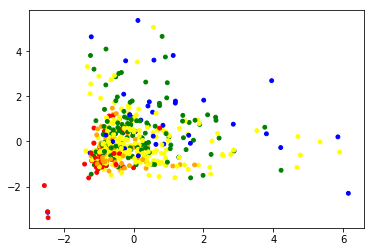

In [20]:
plt.scatter(*zip(*tozip))

### К новым данным применим классификатор.

In [21]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

# Train model
model = clf.fit(X_train_reduced, y_train_full)

err_train = np.mean(y_train_full != clf.predict(X_train_reduced))
err_test = np.mean(y_test_full != clf.predict(X_test_reduced))

print(err_train, err_test)

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.5789351851851852 0.58004158004158


In [22]:
print(classification_report(y_test_full, clf.predict(X_test_reduced)))

              precision    recall  f1-score   support

           5       0.00      0.00      0.00        63
           6       0.49      0.58      0.54       207
           7       0.38      0.33      0.35       125
         <=4       0.32      0.62      0.42        47
         >=8       0.31      0.28      0.30        39

    accuracy                           0.42       481
   macro avg       0.30      0.36      0.32       481
weighted avg       0.37      0.42      0.39       481



#### Мы видим, что показатели обвалились. Это логично, учитывая, насколько колоссальное уменьшение размерности. Попробуем применить SVM.

#### Полная размерность:

In [23]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train_full)

err_train = np.mean(y_train_full != svc.predict(X_train))
err_test  = np.mean(y_test_full  != svc.predict(X_test))

print(err_train, err_test)

print(classification_report(y_test_full, svc.predict(X_test)))

0.4775462962962963 0.5114345114345115


c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           5       0.00      0.00      0.00        63
           6       0.49      0.84      0.62       207
           7       0.47      0.49      0.48       125
         <=4       1.00      0.02      0.04        47
         >=8       0.00      0.00      0.00        39

    accuracy                           0.49       481
   macro avg       0.39      0.27      0.23       481
weighted avg       0.43      0.49      0.40       481



#### Уменьшенная размерность:

In [24]:
svc = SVC(gamma='auto')
svc.fit(X_train_reduced, y_train_full)

err_train = np.mean(y_train_full != svc.predict(X_train_reduced))
err_test  = np.mean(y_test_full  != svc.predict(X_test_reduced))

print(err_train, err_test)

0.524537037037037 0.5613305613305614


In [25]:
print(classification_report(y_test_full, svc.predict(X_test_reduced)))

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           5       0.00      0.00      0.00        63
           6       0.45      0.83      0.58       207
           7       0.38      0.27      0.32       125
         <=4       0.75      0.06      0.12        47
         >=8       0.50      0.05      0.09        39

    accuracy                           0.44       481
   macro avg       0.42      0.24      0.22       481
weighted avg       0.41      0.44      0.35       481



Здесь наблюдаем, что PCA позволяет уменьшить ошибку в SVC.

Исследуем зависимость ошибки от количества главных компонент.

In [26]:
len(X_train[0])

139

In [27]:
depend_list = []

In [28]:
def get_pca():
    
    for i in tqdm(range(1,140)):
        
        pca_new = PCA(n_components = i)
        X_train_red = pca_new.fit_transform(X_train)
        X_test_red = pca_new.transform(X_test)
        
        clf = LogisticRegression(random_state=0, class_weight='balanced')

        model = clf.fit(X_train_red, y_train_full)

        err_train = np.mean(y_train_full != clf.predict(X_train_red))
        err_test = np.mean(y_test_full != clf.predict(X_test_red))
        
        depend_list.append((err_train, err_test, i))

In [29]:
get_pca()

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\use

In [30]:
depend_list

[(0.6168981481481481, 0.5945945945945946, 1),
 (0.5789351851851852, 0.58004158004158, 2),
 (0.5837962962962963, 0.5675675675675675, 3),
 (0.5782407407407407, 0.5717255717255717, 4),
 (0.5363425925925925, 0.49064449064449067, 5),
 (0.5358796296296297, 0.5051975051975052, 6),
 (0.5219907407407407, 0.501039501039501, 7),
 (0.5171296296296296, 0.4885654885654886, 8),
 (0.5115740740740741, 0.4802494802494803, 9),
 (0.5145833333333333, 0.49064449064449067, 10),
 (0.5180555555555556, 0.4760914760914761, 11),
 (0.5115740740740741, 0.48440748440748443, 12),
 (0.5171296296296296, 0.4864864864864865, 13),
 (0.5152777777777777, 0.47193347193347196, 14),
 (0.5120370370370371, 0.4760914760914761, 15),
 (0.5175925925925926, 0.4781704781704782, 16),
 (0.5127314814814815, 0.48232848232848236, 17),
 (0.5141203703703704, 0.48440748440748443, 18),
 (0.5131944444444444, 0.4760914760914761, 19),
 (0.5136574074074074, 0.4864864864864865, 20),
 (0.5138888888888888, 0.4760914760914761, 21),
 (0.511574074074074

In [31]:
train_err, test_err, comps = zip(*depend_list)

Text(0, 0.5, 'Error')

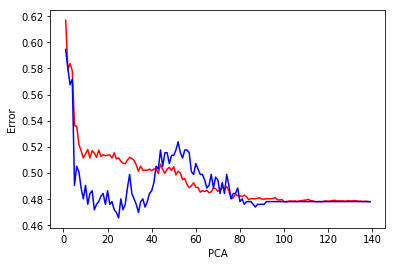

In [32]:
plt.plot(comps, train_err, 'r')
plt.plot(comps, test_err, 'b')
plt.xlabel('PCA')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

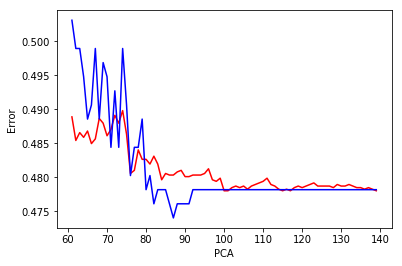

In [33]:
plt.plot(comps[60:], train_err[60:], 'r')
plt.plot(comps[60:], test_err[60:], 'b')
plt.xlabel('PCA')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

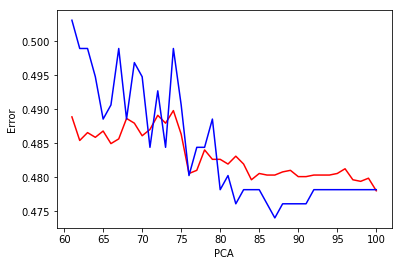

In [34]:
plt.plot(comps[60:100], train_err[60:100], 'r')
plt.plot(comps[60:100], test_err[60:100], 'b')
plt.xlabel('PCA')
plt.ylabel('Error')

Мы видим, что наименьшее значение ошибки на тестовой выборке достигается при выборе 87 компонент. Видно, что PCA действительно позволяет снизить ошибку, и при большем количестве компонентов ошибка тоже выше.